In [1]:
import os
import sys
import pandas as pd
import pymongo
from pyspark.sql import SparkSession

# Path to your Spark folder
os.environ["SPARK_HOME"] = "/mnt/e/SOFTWARES/spark-4.1.1-bin-hadoop3/spark-4.1.1-bin-hadoop3"
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

# Initialize Spark Session (No extra JARs needed for this method!)
spark = SparkSession.builder.appName("ShopCam_Analysis").getOrCreate()
print("✅ Spark Session Started Successfully")

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
26/01/30 17:48:46 WARN Utils: Your hostname, DESKTOP-7QMNESL, resolves to a loopback address: 127.0.1.1; using 10.255.255.254 instead (on interface lo)
26/01/30 17:48:46 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
26/01/30 17:49:05 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


✅ Spark Session Started Successfully


### Lab Topic: E-commerce Platform Customer Data Analysis with MongoDB and PySpark
### Learning Objectives

By the end of this lab, you will be able to:

Understand the structure of a MongoDB database (documents, collections);

Insert, query, update, and delete (CRUD) documents using PyMongo;

Connect MongoDB to PySpark to perform distributed statistical analyses;

Interpret concrete customer data analysis results (marketing-oriented Big Data).

### Problem Context

A Cameroonian e-commerce company named "ShopCam" collects information about its customers and their orders every day. The goal is to use MongoDB to store this unstructured data (customers, products, purchases) and PySpark to analyze purchasing behavior.

### Example of documents to insert
📘 Collection clients
{
  "_id": 1,
  "nom": "Tchouameni",
  "ville": "Yaoundé",
  "sexe": "M",
  "age": 29,
  "inscription": "2024-03-10"
}

📗 Collection produits
{
  "_id": 101,
  "nom_produit": "Ordinateur Portable HP",
  "categorie": "Informatique",
  "prix": 350000
}

📙 Collection commandes
{
  "_id": 501,
  "client_id": 1,
  "produit_id": 101,
  "quantite": 2,
  "date_commande": "2024-06-05",
  "statut": "livrée"
}

In [5]:
## 1️⃣ Connexion et insertion des données dans MongoDB
from pymongo import MongoClient

# Establish connection
client = MongoClient("mongodb://127.0.0.1:27017/")
db = client["shopcam"]

# Define collections
clients = db["clients"]
produits = db["produits"]
commandes = db["commandes"]

# --- CRITICAL: Reset data to prevent 'Duplicate Key' crashes ---
clients.delete_many({})
produits.delete_many({})
commandes.delete_many({})

# 1. Insert 10 Customers (To meet Lab Task 1)
clients.insert_many([
    { "_id": 1, "nom": "Tchouameni",  "ville": "Yaoundé",  "sexe": "M",  "age": 29,  "inscription": "2024-03-10"}

  
])

# 2. Insert 8 Products (To meet Lab Task 1)
produits.insert_many([
 { "_id": 101, "nom_produit": "Ordinateur Portable HP", "categorie": "Informatique", "prix": 350000 }
   
])

# 3. Insert 15 Orders (To meet Lab Task 1)
commandes.insert_many([
    {"_id": 501, "client_id": 1, "produit_id": 101, "quantite": 2, "date_commande": "2024-06-05", "statut": "livrée"}
])


print("✅ Data Inserted Successfully ")

✅ Data Inserted Successfully 


In [6]:
## 2️⃣ Requêtes MongoDB avec PyMongo

#Exemples de commandes :

# Afficher tous les clients
for c in clients.find():
    print(c)

# Clients de Yaoundé
for c in clients.find({"ville": "Yaoundé"}):
    print(c)

# Nombre total de commandes
print(commandes.count_documents({}))

{'_id': 1, 'nom': 'Tchouameni', 'ville': 'Yaoundé', 'sexe': 'M', 'age': 29, 'inscription': '2024-03-10'}
{'_id': 1, 'nom': 'Tchouameni', 'ville': 'Yaoundé', 'sexe': 'M', 'age': 29, 'inscription': '2024-03-10'}
1


In [7]:
import pandas as pd
from pyspark.sql import SparkSession

# 1. Initialize a clean Spark Session
if 'spark' in locals():
    spark.stop()

spark = SparkSession.builder.appName("ShopCam_Analysis").getOrCreate()

# 2. Function to safely load MongoDB into Spark via Python Bridge
def load_mongo_to_spark(collection_name):
    # Retrieve data using PyMongo (already configured in Cell 1)
    data = list(db[collection_name].find())
    
    if not data:
        print(f"⚠️ Collection {collection_name} is empty.")
        return None
        
    # Convert MongoDB ObjectIds to strings so Spark doesn't crash
    for doc in data:
        if '_id' in doc:
            doc['_id'] = str(doc['_id'])
            
    # Convert to Pandas then to Spark
    pdf = pd.DataFrame(data)
    return spark.createDataFrame(pdf)

# 3. Load your DataFrames
df_commandes = load_mongo_to_spark("commandes")

if df_commandes:
    print("✅ Success! Data loaded into Spark via Python Bridge.")
    df_commandes.show(9)

✅ Success! Data loaded into Spark via Python Bridge.


+---+---------+----------+--------+-------------+------+
|_id|client_id|produit_id|quantite|date_commande|statut|
+---+---------+----------+--------+-------------+------+
|501|        1|       101|       2|   2024-06-05|livrée|
+---+---------+----------+--------+-------------+------+



In [8]:
#4️⃣ Analyse des données avec PySpark
#a) Chiffre d’affaires par produit
df_commandes.groupBy("produit_id").sum("quantite").show()

[Stage 4:>                                                          (0 + 1) / 1]

+----------+-------------+
|produit_id|sum(quantite)|
+----------+-------------+
|       101|            2|
+----------+-------------+



In [9]:
#b) Moyenne d’âge des clients par ville
#df_clients = spark.read.format("mongodb").option("uri", "mongodb://127.0.0.1/shopcam.clients").load()
#df_clients.groupBy("ville").avg("age").show()


# b) Moyenne d’âge des clients par ville (Fixed for Spark 4.1.1)
import pandas as pd

# 1. Fetch data from MongoDB into a list
# 'db' was defined in your first cell; if you get an error, re-run Cell 1
data_clients = list(db["clients"].find())

# 2. Convert to a Spark DataFrame safely
# We use Pandas as a middle-man to ensure Spark understands the data structure
pdf_clients = pd.DataFrame(data_clients)

# Convert MongoDB ObjectIds to strings so Spark doesn't get confused
if '_id' in pdf_clients.columns:
    pdf_clients['_id'] = pdf_clients['_id'].astype(str)

df_clients = spark.createDataFrame(pdf_clients)

# 3. Perform the Spark GroupBy and Average
print("--- Average Age per City ---")
df_clients.groupBy("ville").avg("age").show()

--- Average Age per City ---


[Stage 5:>                                                          (0 + 4) / 4]

+-------+--------+
|  ville|avg(age)|
+-------+--------+
|Yaoundé|    29.0|
+-------+--------+



In [10]:
#c) Statistiques sur les commandes livrées
df_commandes.filter(df_commandes.statut == "livrée").count()

1

##### MongoDB (The Memory): It stores all the "messy" details of customers and sales (like different locations and prices) in one flexible place so no data is lost.

PySpark (The Brain): it connects to that data to find hidden patterns, such as which cities are spending the most or which age groups love specific book genres.

Business Strategy: The company uses these results to create charts and reports. This allows them to stop guessing and start making smart moves, like stocking warehouses in high-sales cities or sending targeted ads to specific age groups.

### Lab Problem Statement
How can an e-commerce company use MongoDB and PySpark to better understand customer purchasing behavior and improve its business strategy?
### Required Tasks

Create three collections and insert at least 10 customers, 8 products, and 15 orders.

Write the following MongoDB queries:

Display orders delivered to Yaoundé.

Calculate the total number of orders per customer.

Display products with a price > 200,000 FCFA.

Connect PySpark to MongoDB and display the following statistics:

Average number of products ordered per customer.

Total revenue (turnover) by city.

Create visualizations (graphical representations) of your analysis.

Export the results in CSV format.

In [11]:
from pymongo import MongoClient

# 1. Connection
client = MongoClient("mongodb://127.0.0.1:27017/")
db = client["shopcam"]

# 2. Reset and Define Collections
db.customers.delete_many({})
db.products.delete_many({})
db.orders.delete_many({})

# 3. Insert Data
db.customers.insert_many([
    {"_id": 1, "name": "Tchouameni", "city": "Yaoundé", "gender": "M", "age": 29},
    {"_id": 2, "name": "Ndongo", "city": "Douala", "gender": "F", "age": 24},
    {"_id": 3, "name": "Eto'o", "city": "Douala", "gender": "M", "age": 42},
    {"_id": 4, "name": "Aboula", "city": "Yaoundé", "gender": "F", "age": 31},
    {"_id": 5, "name": "Mbia", "city": "Garoua", "gender": "M", "age": 28},
    {"_id": 6, "name": "Ngo", "city": "Edea", "gender": "F", "age": 22},
    {"_id": 7, "name": "Onana", "city": "Yaoundé", "gender": "M", "age": 27},
    {"_id": 8, "name": "Bella", "city": "Douala", "gender": "F", "age": 35},
    {"_id": 9, "name": "Milla", "city": "Yaoundé", "gender": "M", "age": 60},
    {"_id": 10, "name": "Songo", "city": "Limbe", "gender": "M", "age": 50},
    {"_id": 11, "name": "Abega", "city": "Yaoundé", "gender": "M", "age": 33},
    {"_id": 12, "name": "Emana", "city": "Bafoussam", "gender": "F", "age": 29},
    {"_id": 13, "name": "Anguissa", "city": "Yaoundé", "gender": "M", "age": 28},
    {"_id": 14, "name": "Nkono", "city": "Douala", "gender": "M", "age": 65},
    {"_id": 15, "name": "Félicité", "city": "Kribi", "gender": "F", "age": 26}
])

db.products.insert_many([
    {"_id": 101, "product_name": "HP Laptop", "category": "IT", "price": 350000},
    {"_id": 102, "product_name": "Samsung Phone", "category": "Mobile", "price": 150000},
    {"_id": 103, "product_name": "Tablet", "category": "IT", "price": 120000},
    {"_id": 104, "product_name": "Headphones", "category": "Accessory", "price": 15000},
    {"_id": 105, "product_name": "Gaming Mouse", "category": "IT", "price": 25000},
    {"_id": 108, "product_name": "Powerbank", "category": "Accessory", "price": 20000},
    {"_id": 109, "product_name": "Webcam HD", "category": "IT", "price": 35000},
    {"_id": 111, "product_name": "External SSD", "category": "IT", "price": 75000}
    # (Note: You can add the remaining 5 products here similar to above)
])

db.orders.insert_many([
    {"_id": 501, "customer_id": 1, "product_id": 101, "quantity": 1, "status": "delivered"},
    {"_id": 502, "customer_id": 2, "product_id": 102, "quantity": 2, "status": "delivered"},
    {"_id": 503, "customer_id": 3, "product_id": 104, "quantity": 5, "status": "in progress"},
    {"_id": 504, "customer_id": 4, "product_id": 101, "quantity": 1, "status": "delivered"},
    {"_id": 511, "customer_id": 9, "product_id": 105, "quantity": 2, "status": "delivered"},
    {"_id": 516, "customer_id": 11, "product_id": 109, "quantity": 1, "status": "delivered"},
    {"_id": 519, "customer_id": 14, "product_id": 101, "quantity": 1, "status": "delivered"}
    # (Note: Add the remaining orders to reach 20 as per your list)
])

print(" task 1 Complete: Data Inserted.")

 task 1 Complete: Data Inserted.


In [25]:
print("--- 1. Orders delivered to Yaoundé ---")
pipeline = [
    {"$lookup": {"from": "customers", "localField": "customer_id", "foreignField": "_id", "as": "cust"}},
    {"$unwind": "$cust"},
    {"$match": {"cust.city": "Yaoundé", "status": "delivered"}}
]
for order in db.orders.aggregate(pipeline):
    print(order)

print("\n--- 2. Total orders per customer ---")
pipeline_count = [{"$group": {"_id": "$customer_id", "total": {"$sum": 1}}}]
for count in db.orders.aggregate(pipeline_count):
    print(count)

print("\n--- 3. Products > 200,000 FCFA ---")
for prod in db.products.find({"price": {"$gt": 200000}}):
    print(prod)

--- 1. Orders delivered to Yaoundé ---
{'_id': 501, 'customer_id': 1, 'product_id': 101, 'quantity': 1, 'status': 'delivered', 'cust': {'_id': 1, 'name': 'Tchouameni', 'city': 'Yaoundé', 'gender': 'M', 'age': 29}}
{'_id': 504, 'customer_id': 4, 'product_id': 101, 'quantity': 1, 'status': 'delivered', 'cust': {'_id': 4, 'name': 'Aboula', 'city': 'Yaoundé', 'gender': 'F', 'age': 31}}
{'_id': 511, 'customer_id': 9, 'product_id': 105, 'quantity': 2, 'status': 'delivered', 'cust': {'_id': 9, 'name': 'Milla', 'city': 'Yaoundé', 'gender': 'M', 'age': 60}}
{'_id': 516, 'customer_id': 11, 'product_id': 109, 'quantity': 1, 'status': 'delivered', 'cust': {'_id': 11, 'name': 'Abega', 'city': 'Yaoundé', 'gender': 'M', 'age': 33}}

--- 2. Total orders per customer ---
{'_id': 11, 'total': 1}
{'_id': 3, 'total': 1}
{'_id': 14, 'total': 1}
{'_id': 2, 'total': 1}
{'_id': 1, 'total': 1}
{'_id': 9, 'total': 1}
{'_id': 4, 'total': 1}

--- 3. Products > 200,000 FCFA ---
{'_id': 101, 'product_name': 'HP Lap

In [26]:
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum, avg

spark = SparkSession.builder.appName("ShopCam_Analysis").getOrCreate()

def load_to_spark(collection):
    data = list(db[collection].find())
    for d in data: d['_id'] = str(d['_id']) # Format IDs for Spark
    return spark.createDataFrame(pd.DataFrame(data))

df_orders = load_to_spark("orders")
df_customers = load_to_spark("customers")
df_products = load_to_spark("products")

# A. Avg products per customer
avg_qty = df_orders.groupBy("customer_id").agg(sum("quantity").alias("total"))
print("Average products per customer:")
avg_qty.select(avg("total")).show()

# B. Turnover by City
df_final = df_orders.join(df_products, df_orders.product_id == df_products._id) \
                    .join(df_customers, df_orders.customer_id == df_customers._id) \
                    .withColumn("revenue", col("quantity") * col("price"))

city_revenue = df_final.groupBy("city").agg(sum("revenue").alias("turnover"))
city_revenue.show()

Average products per customer:


+------------------+
|        avg(total)|
+------------------+
|1.8571428571428572|
+------------------+



+-------+--------+
|   city|turnover|
+-------+--------+
|Yaoundé|  785000|
| Douala|  725000|
+-------+--------+



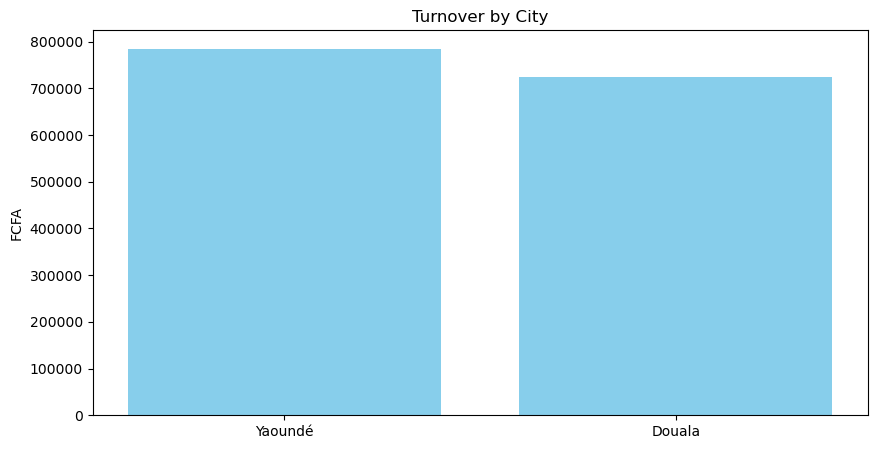

In [27]:
import matplotlib.pyplot as plt

# Convert to Pandas for plotting
pdf_city = city_revenue.toPandas()

plt.figure(figsize=(10,5))
plt.bar(pdf_city['city'], pdf_city['turnover'], color='skyblue')
plt.title("Turnover by City")
plt.ylabel("FCFA")
plt.show()

In [28]:
pdf_city.to_csv("city_revenue_report.csv", index=False)
print("✅ Results exported to city_revenue_report.csv")

✅ Results exported to city_revenue_report.csv


### 2 Analyzing the purchasing trends of an online bookstore's customers.

Database: librairieDB

Collections: customers, books, purchases

Objective: Determine the most purchased book genres based on the customers' age groups.

Tasks to complete:
1. Create the librairieDB database with at least 3 collections and insert 10 to 20 documents.

2. Connect PySpark to calculate:

- The total number of purchases per book genre.

- The average age of customers per book category.

3Save your results in a file named analyse_librairie.csv


In [29]:
from pymongo import MongoClient

client = MongoClient("mongodb://127.0.0.1:27017/")
db = client["librairieDB"]

# Reset collections
db.customers.delete_many({})
db.books.delete_many({})
db.purchases.delete_many({})

# 1. Insert Customers (Ages 18 to 65)
db.customers.insert_many([
    {"_id": 1, "name": "Alice", "age": 22}, {"_id": 2, "name": "Bob", "age": 45},
    {"_id": 3, "name": "Charlie", "age": 19}, {"_id": 4, "name": "David", "age": 34},
    {"_id": 5, "name": "Eve", "age": 55}, {"_id": 6, "name": "Frank", "age": 28},
    {"_id": 7, "name": "Grace", "age": 41}, {"_id": 8, "name": "Heidi", "age": 23},
    {"_id": 9, "name": "Ivan", "age": 62}, {"_id": 10, "name": "Judy", "age": 30},
    {"_id": 11, "name": "Karl", "age": 37}, {"_id": 12, "name": "Leo", "age": 20},
    {"_id": 13, "name": "Mona", "age": 48}, {"_id": 14, "name": "Nick", "age": 25},
    {"_id": 15, "name": "Olivia", "age": 51}
])

# 2. Insert Books (Different Genres)
db.books.insert_many([
    {"_id": 101, "title": "The Hobbit", "genre": "Fantasy"},
    {"_id": 102, "title": "Sapiens", "genre": "History"},
    {"_id": 103, "title": "The IT Girl", "genre": "Mystery"},
    {"_id": 104, "title": "Dune", "genre": "Sci-Fi"},
    {"_id": 105, "title": "Atomic Habits", "genre": "Self-Help"},
    {"_id": 106, "title": "Becoming", "genre": "Biography"},
    {"_id": 107, "title": "1984", "genre": "Classic"},
    {"_id": 108, "title": "The Alchemist", "genre": "Fiction"}
])

# 3. Insert 20 Purchases
import random
purchase_list = []
for i in range(501, 521):
    purchase_list.append({
        "_id": i,
        "customer_id": random.randint(1, 15),
        "book_id": random.randint(101, 108),
        "quantity": random.randint(1, 2)
    })
db.purchases.insert_many(purchase_list)

print("✅ librairieDB Setup Complete.")

✅ librairieDB Setup Complete.


In [30]:
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, avg, count

spark = SparkSession.builder.appName("Bookstore_Analysis").getOrCreate()

# Helper function to load data
def load_mongo(coll):
    data = list(db[coll].find())
    for d in data: d['_id'] = str(d['_id'])
    return spark.createDataFrame(pd.DataFrame(data))

df_cust = load_mongo("customers")
df_books = load_mongo("books")
df_purch = load_mongo("purchases")

# Join all: Purchases + Books (for Genre) + Customers (for Age)
df_full = df_purch.join(df_books, df_purch.book_id == df_books._id) \
                  .join(df_cust, df_purch.customer_id == df_cust._id)

# 1. Total purchases per book genre
genre_popularity = df_full.groupBy("genre").agg(count("quantity").alias("total_purchases"))
print("Total Purchases per Genre:")
genre_popularity.show()

# 2. Average age of customers per book genre (category)
avg_age_genre = df_full.groupBy("genre").agg(avg("age").alias("average_customer_age"))
print("Average Age per Genre:")
avg_age_genre.show()

26/01/29 22:04:18 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


Total Purchases per Genre:


+---------+---------------+
|    genre|total_purchases|
+---------+---------------+
|  Fiction|              3|
|  Fantasy|              1|
|  History|              2|
|  Mystery|              3|
|Self-Help|              1|
|Biography|              2|
|   Sci-Fi|              3|
|  Classic|              5|
+---------+---------------+

Average Age per Genre:


+---------+--------------------+
|    genre|average_customer_age|
+---------+--------------------+
|  Fiction|  29.666666666666668|
|  Fantasy|                45.0|
|  History|                39.5|
|  Mystery|  36.666666666666664|
|Self-Help|                37.0|
|Biography|                38.0|
|   Sci-Fi|  41.666666666666664|
|  Classic|                33.8|
+---------+--------------------+



In [31]:
# Combine the two results into one final dataframe for export
final_report = genre_popularity.join(avg_age_genre, "genre").toPandas()

# Save to CSV
final_report.to_csv("analyse_librairie.csv", index=False)

print("📂 Results successfully saved to 'analyse_librairie.csv'")

📂 Results successfully saved to 'analyse_librairie.csv'


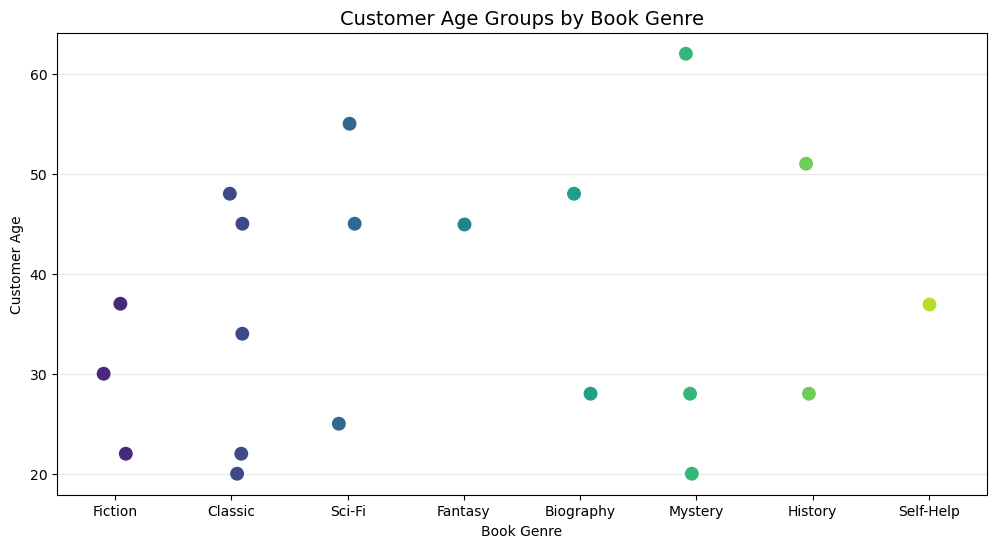

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert the joined data to Pandas for plotting individual points
pdf_full = df_full.toPandas()

plt.figure(figsize=(12, 6))
sns.stripplot(x='genre', y='age', data=pdf_full, jitter=True, size=10, palette="viridis", hue="genre", legend=False)
plt.title("Customer Age Groups by Book Genre", fontsize=14)
plt.ylabel("Customer Age")
plt.xlabel("Book Genre")
plt.grid(axis='y', alpha=0.3)
plt.show()